# **1. Instalación y preparación del entorno de trabajo**

In [1]:
!pip install pyomo highspy folium pandas numpy

import sys
import pandas as pd
import numpy as np
from math import cos, pi
from pyomo.environ import (
    ConcreteModel, Set, Param, Var, NonNegativeReals, Binary,
    Objective, Constraint, SolverFactory, value, minimize
)
import folium

if "google.colab" in sys.modules:
    print("Instalando Pyomo y solvers en Colab ...")

    # Descargar script helper
    !wget -q "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"

    # Instalar todo lo necesario
    import helper
    helper.install_idaes()
    helper.install_glpk()
    helper.install_ipopt()

    print("Install successful")
else:
    print("Something went wrong")


Instalando Pyomo y solvers en Colab ...
Installing idaes via pip...
idaes was successfully installed
Installing glpk via apt-get...
Running idaes get-extensions to install Ipopt, k_aug, and more...
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)

[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne (x86_64-pc-linux-gnu), ASL(20190605)

Bonmin 1.8.8 using Cbc 2.10.10 and Ipopt 3.13.2
bonmin (x86_64-pc-linux-gnu), ASL(20190605)

Ipopt 3.13.3 (x86_64-pc-linux-gnu), ASL(20190605)

ipopt was successfully installed
k_aug was successfuly installed
cbc was successfuly installed
clp was successfuly installed
bonmin was successfuly installed
couenne was successfuly installed
ipopt_l1 was successfuly installed
 
Install successful


# **2. Carga de datos**

In [2]:
CLIENTS_PATH = "clients.csv"
VEHICLES_PATH = "vehicles.csv"
DEPOTS_PATH = "depots.csv"
PARAMS_PATH = "parameters_urban.csv"

clients_df = pd.read_csv(CLIENTS_PATH)
vehicles_df = pd.read_csv(VEHICLES_PATH)
depots_df = pd.read_csv(DEPOTS_PATH)
params_df = pd.read_csv(PARAMS_PATH)

print("Clientes:", clients_df.shape)
print("Vehículos:", vehicles_df.shape)
print("Depósitos:", depots_df.shape)
print("Parámetros:", params_df.shape)

clients_df.head(), vehicles_df.head(), depots_df.head(), params_df.head()


Clientes: (9, 6)
Vehículos: (6, 5)
Depósitos: (12, 6)
Parámetros: (10, 4)


(   ClientID StandardizedID  LocationID  Latitude  Longitude  Demand
 0         1           C001          13  4.632553 -74.196992      12
 1         2           C002          14  4.601328 -74.155037      15
 2         3           C003          15  4.732421 -74.101787      15
 3         4           C004          16  4.638612 -74.194862       6
 4         5           C005          17  4.727692 -74.110272       5,
    VehicleID StandardizedID  VehicleType    Capacity        Range
 0          1           V001    small van  131.921140   145.852071
 1          2           V002   medium van  108.435620  1304.605971
 2          3           V003   medium van   91.504255   953.172609
 3          4           V004  light truck   32.896064    17.302304
 4          5           V005   medium van   22.652628    16.627680,
    DepotID StandardizedID  LocationID  Longitude  Latitude  Capacity
 0        1           CD01           1 -74.081242  4.750212         8
 1        2           CD02           2 -74

# **3. Procesamiento**

## **3.1 Parámetros**

In [3]:
param_values = params_df.set_index("Parameter")["Value"].to_dict()

C_FIXED = float(param_values.get("C_fixed", 50000))        # COP/vehículo
C_DIST  = float(param_values.get("C_dist", 2500))          # COP/km
C_TIME  = float(param_values.get("C_time", 7600))          # COP/hora
FUEL_PRICE = float(param_values.get("fuel_price", 16300))  # COP/galón

AVG_SPEED_KMH = float(param_values.get("avg_speed_kmh", 25.0))

print(C_FIXED, C_DIST, C_TIME, FUEL_PRICE, AVG_SPEED_KMH)


50000.0 2500.0 7600.0 16300.0 25.0


## **3.2 Nodos**
* Conjunto de clientes C

* Conjunto de depósitos D

* Conjunto de nodos N = C ∪ D

In [4]:
# Conjuntos de IDs
client_ids = clients_df["ClientID"].tolist()
vehicle_ids = vehicles_df["VehicleID"].tolist()
depot_ids = depots_df["DepotID"].tolist()

# Nodos: LocationID
client_nodes = clients_df["LocationID"].tolist()
depot_nodes = depots_df["LocationID"].tolist()
all_nodes = sorted(set(client_nodes) | set(depot_nodes))

# Mapas auxiliares
loc_to_coords = {}

# Clientes
for _, row in clients_df.iterrows():
    loc_to_coords[row["LocationID"]] = (row["Latitude"], row["Longitude"])

# Depósitos
for _, row in depots_df.iterrows():
    loc_to_coords[row["LocationID"]] = (row["Latitude"], row["Longitude"])

# Mapas para StandardizedID (para archivo de verificación)
client_loc_to_std = {row["LocationID"]: row["StandardizedID"]
                     for _, row in clients_df.iterrows()}
depot_loc_to_std  = {row["LocationID"]: row["StandardizedID"]
                     for _, row in depots_df.iterrows()}
vehicle_id_to_std = {row["VehicleID"]: row["StandardizedID"]
                     for _, row in vehicles_df.iterrows()}

# Demandas y capacidades
demand_by_loc = {row["LocationID"]: float(row["Demand"])
                 for _, row in clients_df.iterrows()}

depot_capacity_by_loc = {row["LocationID"]: float(row["Capacity"])
                         for _, row in depots_df.iterrows()}

vehicle_capacity = {row["VehicleID"]: float(row["Capacity"])
                    for _, row in vehicles_df.iterrows()}

vehicle_range = {row["VehicleID"]: float(row["Range"])
                 for _, row in vehicles_df.iterrows()}

vehicle_type = {row["VehicleID"]: str(row["VehicleType"]).strip().lower()
                for _, row in vehicles_df.iterrows()}


## **3.3 Distancias con Manhattan**

In [5]:
def manhattan_km(lat1, lon1, lat2, lon2):
    # aproximación de 1 grado de latitud ≈ 111 km
    dlat_km = 111.0 * abs(lat1 - lat2)
    lat_mean_rad = ((lat1 + lat2) / 2.0) * pi / 180.0
    dlon_km = 111.0 * cos(lat_mean_rad) * abs(lon1 - lon2)
    return dlat_km + dlon_km

dist_dict = {}
for i in all_nodes:
    lat_i, lon_i = loc_to_coords[i]
    for j in all_nodes:
        lat_j, lon_j = loc_to_coords[j]
        if i == j:
            dist_dict[(i, j)] = 0.0
        else:
            dist_dict[(i, j)] = manhattan_km(lat_i, lon_i, lat_j, lon_j)

len(dist_dict), list(dist_dict.items())[:5]


(441,
 [((1, 1), 0.0),
  ((1, 2), 26.90927789812288),
  ((1, 3), 9.463873428189313),
  ((1, 4), 4.735158731638508),
  ((1, 5), 22.126299480711918)])

## **3.4 Eficiencias por vehículo**

In [6]:
type_efficiency_km_per_gal = {
    "small van":  (35 + 45) / 2.0,
    "medium van": (25 + 35) / 2.0,
    "light truck": (22 + 28) / 2.0
}

vehicle_eff = {}
for v in vehicle_ids:
    vt = vehicle_type[v]
    eff = type_efficiency_km_per_gal.get(vt, 30.0)  # default 30 km/gal
    vehicle_eff[v] = eff

vehicle_eff


{1: 40.0, 2: 30.0, 3: 30.0, 4: 25.0, 5: 30.0, 6: 25.0}

# **4. Modelo**

## **4.1 Conjuntos**

In [7]:
model = ConcreteModel()

# Conjuntos
model.N = Set(initialize=all_nodes)               # nodos (locationID)
model.C = Set(initialize=client_nodes)            # clientes (locationID)
model.D = Set(initialize=depot_nodes)             # depósitos (locationID)
model.V = Set(initialize=vehicle_ids)             # vehículos (VehicleID)

# Conjunto de arcos (i, j) con i != j
arcs = [(i, j) for i in all_nodes for j in all_nodes if i != j]
model.A = Set(dimen=2, initialize=arcs)



## **4.2 Parámetros**

In [8]:
# Distancias
dist_arcs = { (i, j): dist_dict[(i, j)] for (i, j) in arcs }
model.dist = Param(model.A, initialize=dist_arcs, within=NonNegativeReals)

# Demandas (solo clientes; para otros nodos = 0)
def demand_init(m, n):
    return float(demand_by_loc.get(n, 0.0))
model.demand = Param(model.N, initialize=demand_init, within=NonNegativeReals)

# Capacidad de depósitos
def depot_cap_init(m, n):
    return float(depot_capacity_by_loc.get(n, 0.0))
model.depot_capacity = Param(model.D, initialize=depot_cap_init, within=NonNegativeReals)

# Capacidad y rango de vehículos
model.capacity_v = Param(model.V, initialize=vehicle_capacity, within=NonNegativeReals)
model.range_v    = Param(model.V, initialize=vehicle_range, within=NonNegativeReals)

# Velocidad y eficiencia por vehículo
model.speed_v = Param(model.V, initialize={v: AVG_SPEED_KMH for v in vehicle_ids}, within=NonNegativeReals)
model.eff_v   = Param(model.V, initialize=vehicle_eff, within=NonNegativeReals)

# Parámetros globales de costo
model.C_fixed     = Param(initialize=C_FIXED)
model.C_dist      = Param(initialize=C_DIST)
model.C_time      = Param(initialize=C_TIME)
model.fuel_price  = Param(initialize=FUEL_PRICE)


## **4.3 Variables de decisión**

In [9]:
# x[i,j,v] = 1 si el vehículo v recorre arco i->j
model.x = Var(model.A, model.V, domain=Binary)

# q[c,v] = cantidad entregada al cliente c por el vehículo v (kg)
# (c está indexado por LocationID de cliente, como en model.C)
model.q = Var(model.C, model.V, domain=NonNegativeReals)

# z[v,s] = 1 si el vehículo v está asignado al depósito s (sale y regresa a s)
model.z = Var(model.V, model.D, domain=Binary)

# y_use[v] = 1 si el vehículo v se usa
model.y_use = Var(model.V, domain=Binary)

# Distancia total y tiempo total por vehículo
model.dist_v = Var(model.V, domain=NonNegativeReals)
model.time_v = Var(model.V, domain=NonNegativeReals)

# Variables MTZ para cortar subtours (orden de visita de clientes)
n_clients = len(client_nodes)
model.u = Var(model.C, model.V, bounds=(0, n_clients))

# load_vs[v,s] = carga total (kg) que el vehículo v saca del depósito s
model.load_vs = Var(model.V, model.D, domain=NonNegativeReals)



## **4.4 Restricciones**

### 4.4.1 Distancia - Autonomía

In [10]:
def dist_def_rule(m, v):
    return m.dist_v[v] == sum(m.dist[i,j] * m.x[i,j,v] for (i,j) in m.A)
model.dist_def = Constraint(model.V, rule=dist_def_rule)

def range_rule(m, v):
    return m.dist_v[v] <= m.range_v[v]
model.range_con = Constraint(model.V, rule=range_rule)


### 4.4.2 Tiempo

In [11]:
def time_def_rule(m, v):
    return m.time_v[v] == m.dist_v[v] / m.speed_v[v]
model.time_def = Constraint(model.V, rule=time_def_rule)


### 4.4.3 Visita única de cliente

In [12]:
def one_visit_rule(m, c):
    return sum(m.x[i,c,v] for v in m.V for i in m.N if (i,c) in m.A) == 1
model.one_visit = Constraint(model.C, rule=one_visit_rule)


### 4.4.4 Conservación de flujo

In [13]:
def flow_conservation_clients_rule(m, v, c):
    return sum(m.x[i,c,v] for i in m.N if (i,c) in m.A) == \
           sum(m.x[c,j,v] for j in m.N if (c,j) in m.A)
model.flow_clients = Constraint(model.V, model.C, rule=flow_conservation_clients_rule)


### 4.4.5 Asignación de vehículos

In [14]:
def assign_vehicle_rule(m, v):
    return sum(m.z[v,s] for s in m.D) == m.y_use[v]
model.assign_vehicle = Constraint(model.V, rule=assign_vehicle_rule)

def start_depot_rule(m, v, s):
    return sum(m.x[s,j,v] for j in m.N if (s,j) in m.A) == m.z[v,s]
model.start_depot = Constraint(model.V, model.D, rule=start_depot_rule)

def end_depot_rule(m, v, s):
    return sum(m.x[i,s,v] for i in m.N if (i,s) in m.A) == m.z[v,s]
model.end_depot = Constraint(model.V, model.D, rule=end_depot_rule)


### 4.4.6 Arcos relevantes

In [15]:
def no_inter_depot_rule(m, v, s1, s2):
    if s1 != s2 and (s1, s2) in m.A:
        return m.x[s1, s2, v] == 0
    return Constraint.Skip
model.no_inter_depot = Constraint(model.V, model.D, model.D, rule=no_inter_depot_rule)

def no_loops_rule(m, v, i):
    if (i, i) in m.A:
        return m.x[i, i, v] == 0
    return Constraint.Skip
model.no_loops = Constraint(model.V, model.N, rule=no_loops_rule)


### 4.4.7 Flujo de carga y demanda

In [16]:
def demand_satisfaction_rule(m, c):
    return sum(m.q[c, v] for v in m.V) == m.demand[c]
model.DemandSatisfaction = Constraint(model.C, rule=demand_satisfaction_rule)

def link_q_x_rule(m, c, v):
    # número de veces que v entra a c
    visits_v_c = sum(m.x[i, c, v] for i in m.N if (i, c) in m.A)
    return m.q[c, v] <= m.demand[c] * visits_v_c
model.LinkQX = Constraint(model.C, model.V, rule=link_q_x_rule)

def vehicle_capacity_rule(m, v):
    return sum(m.q[c, v] for c in m.C) <= m.capacity_v[v]
model.VehicleCapacity = Constraint(model.V, rule=vehicle_capacity_rule)

BIG_M = max(vehicle_capacity.values())

# Carga desde un CD no puede superar la capacidad del vehículo,
# y es cero si el vehículo no está asignado a ese CD.
def load_vs_upper_rule(m, v, s):
    return m.load_vs[v, s] <= m.capacity_v[v] * m.z[v, s]
model.LoadVSUpper = Constraint(model.V, model.D, rule=load_vs_upper_rule)

# load_vs[v,s] ≈ total de carga que reparte v si está asignado a s.
def load_vs_consistency_rule(m, v, s):
    total_load_v = sum(m.q[c, v] for c in m.C)
    # Si z[v,s]=1 -> load_vs[v,s] >= total_load_v
    # Si z[v,s]=0 -> load_vs[v,s] >= total_load_v - Cap_v (relaja)
    return m.load_vs[v, s] >= total_load_v - m.capacity_v[v] * (1 - m.z[v, s])
model.LoadVSConsistency = Constraint(model.V, model.D, rule=load_vs_consistency_rule)

# Capacidad de inventario del depósito s
def depot_inventory_rule(m, s):
    return sum(m.load_vs[v, s] for v in m.V) <= m.depot_capacity[s]
model.DepotInventory = Constraint(model.D, rule=depot_inventory_rule)


### 4.4.8 Eliminación de subtours

In [17]:
def mtz_rule(m, v, i, j):
    if i == j:
        return Constraint.Skip
    if (i not in m.C) or (j not in m.C):
        return Constraint.Skip
    return m.u[i, v] - m.u[j, v] + n_clients * m.x[i,j,v] <= n_clients - 1

model.mtz = Constraint(model.V, model.C, model.C, rule=mtz_rule)


## **4.5 Función Objetivo**

In [18]:
def obj_rule(m):
    fixed_cost = m.C_fixed * sum(m.y_use[v] for v in m.V)
    dist_cost  = m.C_dist  * sum(m.dist_v[v] for v in m.V)
    time_cost  = m.C_time  * sum(m.time_v[v] for v in m.V)
    fuel_cost  = sum((m.dist_v[v] / m.eff_v[v]) * m.fuel_price for v in m.V)
    return fixed_cost + dist_cost + time_cost + fuel_cost

model.obj = Objective(rule=obj_rule, sense=minimize)


## **4.6 Resolver con HiGHS**

In [19]:
from pyomo.opt import TerminationCondition, SolverStatus

solver = SolverFactory("highs")

results = solver.solve(model, tee=True)

print("Status:", results.solver.status)
print("Termination:", results.solver.termination_condition)

if (results.solver.status == SolverStatus.ok and
    results.solver.termination_condition == TerminationCondition.optimal):
    print("Valor óptimo:", value(model.obj))
else:
    print("No se alcanzó optimalidad (o el solver terminó de otra forma).")


Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 1680 rows; 2790 cols; 13224 nonzeros; 2598 integer variables (2598 binary)
Coefficient ranges:
  Matrix  [4e-02, 1e+02]
  Cost    [3e+03, 5e+04]
  Bound   [1e+00, 9e+00]
  RHS     [1e+00, 1e+03]
Presolving model
860 rows, 1980 cols, 9972 nonzeros  0s
795 rows, 776 cols, 4717 nonzeros  0s
607 rows, 724 cols, 4216 nonzeros  0s
581 rows, 671 cols, 4004 nonzeros  0s
Presolve reductions: rows 581(-1099); columns 671(-2119); nonzeros 4004(-9220) 

Solving MIP model with:
   581 rows
   671 cols (527 binary, 0 integer, 0 implied int., 144 continuous, 0 domain fixed)
   4004 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower

# **5. Verificación**

## **5.1 reconstruir rutas**

In [20]:
from collections import defaultdict

def get_vehicle_routes(model):
    routes = {}
    for v in model.V:
        # encontrar depósito de origen
        depots_used = [s for s in model.D if value(model.z[v,s]) > 0.5]
        if not depots_used:
            continue  # vehículo no se usa
        depot = depots_used[0]

        # construir grafo de sucesión para este vehículo
        successors = {}
        for (i,j) in model.A:
            if value(model.x[i,j,v]) > 0.5:
                successors[i] = j

        # reconstruir secuencia: depot -> ... -> depot
        route = [depot]
        current = depot
        visited_protection = set([depot])
        while True:
            if current not in successors:
                # ruta rota
                break
            nxt = successors[current]
            route.append(nxt)
            if nxt == depot:
                break
            if nxt in visited_protection:
                break
            visited_protection.add(nxt)
            current = nxt

        routes[v] = route
    return routes

routes = get_vehicle_routes(model)
routes


{1: [9, 15, 17, 20, 19, 9],
 2: [5, 18, 14, 5],
 3: [12, 16, 13, 12],
 5: [11, 21, 11]}

## **5.2 Verificar**

In [21]:
records = []

for v, route in routes.items():
    if len(route) < 2:
        continue

    # nodos en ruta
    nodes = route

    # depot (primer nodo)
    depot_node = nodes[0]
    depot_std = depot_loc_to_std.get(depot_node, f"CD?{depot_node}")

    # clientes en la ruta (excluyendo nodos de depósito)
    client_nodes_in_route = [n for n in nodes if n in client_loc_to_std]

    # RouteSequence en StandardizedID
    seq_std = []
    for n in nodes:
        if n in depot_loc_to_std:
            seq_std.append(depot_loc_to_std[n])
        elif n in client_loc_to_std:
            seq_std.append(client_loc_to_std[n])
        else:
            seq_std.append(f"UNK{n}")
    route_sequence = "-".join(seq_std)

    # ClientsServed
    clients_served = len(client_nodes_in_route)

    # DemandsSatisfied en orden
    demands_list = [float(value(model.q[n, v])) for n in client_nodes_in_route]
    demands_satisfied = "-".join(str(int(round(d))) for d in demands_list)

    # InitialLoad = suma de demandas de esos clientes
    initial_load = sum(demands_list)

    # Distancia y tiempo
    total_distance = float(value(model.dist_v[v]))
    total_time_hours = float(value(model.time_v[v]))
    total_time_minutes = total_time_hours * 60.0

    # Fuel cost
    eff_v = float(value(model.eff_v[v]))
    fuel_cost = (total_distance / eff_v) * float(value(model.fuel_price))

    records.append({
        "VehicleId": vehicle_id_to_std.get(v, f"V?{v}"),
        "DepotId": depot_std,
        "InitialLoad": initial_load,
        "RouteSequence": route_sequence,
        "ClientsServed": clients_served,
        "DemandsSatisfied": demands_satisfied,
        "TotalDistance": round(total_distance, 3),
        "TotalTime": round(total_time_minutes, 3),
        "FuelCost": round(fuel_cost, 0)
    })

verif_df = pd.DataFrame(records)
verif_df


,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,TotalDistance,TotalTime,FuelCost
0,V001,CD09,42.0,CD09-C003-C005-C008-C007-CD09,4,15-5-10-12,30.296,72.711,12346.0
1,V002,CD05,26.0,CD05-C006-C002-CD05,2,11-15,17.847,42.834,9697.0
2,V003,CD12,18.0,CD12-C004-C001-CD12,2,6-12,29.327,70.386,15935.0
3,V005,CD11,15.0,CD11-C009-CD11,1,15,8.952,21.484,4864.0


## **5.3 Guardar**

In [22]:
OUTPUT_VERIF_PATH = "verificacion_caso2.csv"
verif_df.to_csv(OUTPUT_VERIF_PATH, index=False)
print(f"Archivo de verificación guardado en {OUTPUT_VERIF_PATH}")


Archivo de verificación guardado en verificacion_caso2.csv


# **6. Resultados**

## **6.1 Mapa de rutas**

In [23]:
# Centro aproximado (promedio de coordenadas)
all_lats = [lat for (lat, lon) in loc_to_coords.values()]
all_lons = [lon for (lat, lon) in loc_to_coords.values()]
center_lat = sum(all_lats) / len(all_lats)
center_lon = sum(all_lons) / len(all_lons)

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Depósitos
for loc in depot_nodes:
    lat, lon = loc_to_coords[loc]
    folium.Marker(
        location=[lat, lon],
        popup=f"Depot {depot_loc_to_std[loc]}",
        icon=folium.Icon(icon="home")
    ).add_to(m)

# Clientes
for loc in client_nodes:
    lat, lon = loc_to_coords[loc]
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=f"Client {client_loc_to_std[loc]}"
    ).add_to(m)

# Colores simples
colors = ["red", "blue", "green", "purple", "orange", "darkred",
          "lightred", "beige", "darkblue", "darkgreen", "cadetblue"]

def color_for_depot(depot_loc):
    idx = depot_nodes.index(depot_loc) % len(colors)
    return colors[idx]

# Rutas
for v, route in routes.items():
    if len(route) < 2:
        continue
    depot_loc = route[0]
    color = color_for_depot(depot_loc)
    coords = [loc_to_coords[n] for n in route]
    folium.PolyLine(
        locations=[(lat, lon) for (lat, lon) in coords],
        popup=f"Vehicle {vehicle_id_to_std[v]}",
        weight=3,
        opacity=0.8
    ).add_to(m)

m


## **6.2 Utilización de depósitos**

In [24]:
# Inventario usado por depósito usando load_vs[v,s]
depot_used = {s: 0.0 for s in depot_nodes}

for s in depot_nodes:
    total_from_s = 0.0
    for v in model.V:
        total_from_s += float(value(model.load_vs[v, s]))
    depot_used[s] = total_from_s

depot_summary = []
for s in depot_nodes:
    cap = depot_capacity_by_loc[s]
    used = depot_used[s]
    util = 100 * used / cap if cap > 0 else 0.0
    depot_summary.append({
        "DepotId": depot_loc_to_std[s],
        "Capacity": cap,
        "Used": used,
        "Utilization_%": util
    })

depot_summary_df = pd.DataFrame(depot_summary)
depot_summary_df


,DepotId,Capacity,Used,Utilization_%
0,CD01,8.0,0.0,0.000000
1,CD02,10.0,0.0,0.000000
2,CD03,0.0,0.0,0.000000
3,CD04,4.0,0.0,0.000000
4,CD05,28.0,26.0,92.857143
5,CD06,3.0,0.0,0.000000
6,CD07,0.0,0.0,0.000000
7,CD08,10.0,0.0,0.000000
8,CD09,43.0,43.0,100.000000
9,CD10,1.0,0.0,0.000000


## **6.3 Utilización de vehículos**

In [25]:
vehicle_loads = []
for v in model.V:
    load_v = sum(float(value(model.q[c, v])) for c in model.C)
    vehicle_loads.append({
        "VehicleId": vehicle_id_to_std[v],
        "Load": load_v,
        "Capacity": vehicle_capacity[v],
        "Utilization_%": 100 * load_v / vehicle_capacity[v]
    })

vehicle_loads_df = pd.DataFrame(vehicle_loads)
vehicle_loads_df


,VehicleId,Load,Capacity,Utilization_%
0,V001,42.0,131.921140,31.837202
1,V002,26.0,108.435620,23.977361
2,V003,18.0,91.504255,19.671216
3,V004,0.0,32.896064,0.000000
4,V005,15.0,22.652628,66.217482
5,V006,0.0,22.682912,0.000000


## **6.4 Demanda por cliente**

In [26]:
from pyomo.environ import value

client_rows = []

for c in model.C:
    demand = float(value(model.demand[c]))
    delivered = sum(float(value(model.q[c, v])) for v in model.V)

    # vehiculo que atendió al cliente (el que tenga q[c,v] > 0)
    vehicles_serving = [v for v in model.V if value(model.q[c, v]) > 1e-6]
    if vehicles_serving:
        v = vehicles_serving[0]
        veh_std = vehicle_id_to_std[v]
        # depósito del vehículo
        depots_v = [s for s in model.D if value(model.z[v, s]) > 0.5]
        depot = depots_v[0] if depots_v else None
        depot_std = depot_loc_to_std.get(depot, None)
    else:
        v = None
        veh_std = None
        depot = None
        depot_std = None

    client_rows.append({
        "ClientId": client_loc_to_std[c],
        "Demand": demand,
        "Delivered": delivered,
        "Fulfillment_%": 100 * delivered / demand if demand > 0 else 0,
        "VehicleId": veh_std,
        "DepotId": depot_std
    })

clients_demand_df = pd.DataFrame(client_rows).sort_values("ClientId")
clients_demand_df


,ClientId,Demand,Delivered,Fulfillment_%,VehicleId,DepotId
0,C001,12.0,12.0,100.0,V003,CD12
1,C002,15.0,15.0,100.0,V002,CD05
2,C003,15.0,15.0,100.0,V001,CD09
3,C004,6.0,6.0,100.0,V003,CD12
4,C005,5.0,5.0,100.0,V001,CD09
5,C006,11.0,11.0,100.0,V002,CD05
6,C007,12.0,12.0,100.0,V001,CD09
7,C008,10.0,10.0,100.0,V001,CD09
8,C009,15.0,15.0,100.0,V005,CD11


## **6.5 Vehículos por cliente**

In [27]:
# Orden consistente
client_list = sorted(list(model.C), key=lambda c: client_loc_to_std[c])
vehicle_list = sorted(list(model.V))

data = []
for v in vehicle_list:
    row = []
    for c in client_list:
        row.append(float(value(model.q[c, v])))
    data.append(row)

columns = [client_loc_to_std[c] for c in client_list]
index = [vehicle_id_to_std[v] for v in vehicle_list]

vehicle_client_matrix_df = pd.DataFrame(data, index=index, columns=columns)
vehicle_client_matrix_df


,C001,C002,C003,C004,C005,C006,C007,C008,C009
V001,0.0,0.0,15.0,0.0,5.0,0.0,12.0,10.0,0.0
V002,0.0,15.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0
V003,12.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
V004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
V006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **6.6 Gastos por vehículo**

In [28]:
vehicle_rows = []

for v in model.V:
    veh_std = vehicle_id_to_std[v]

    # CD asignado
    depots_v = [s for s in model.D if value(model.z[v, s]) > 0.5]
    depot = depots_v[0] if depots_v else None
    depot_std = depot_loc_to_std.get(depot, None)

    # carga total del vehículo (suma de q[c,v])
    load_v = sum(float(value(model.q[c, v])) for c in model.C)
    cap_v = vehicle_capacity[v]
    util = 100 * load_v / cap_v if cap_v > 0 else 0

    # distancia y tiempo
    dist_v = float(value(model.dist_v[v]))
    time_v = float(value(model.time_v[v]))  # horas

    vehicle_rows.append({
        "VehicleId": veh_std,
        "DepotId": depot_std,
        "Load": load_v,
        "Capacity": cap_v,
        "Utilization_%": util,
        "Distance_km": dist_v,
        "Time_h": time_v
    })

vehicle_summary_df = pd.DataFrame(vehicle_rows).sort_values(["DepotId", "VehicleId"])
vehicle_summary_df


,VehicleId,DepotId,Load,Capacity,Utilization_%,Distance_km,Time_h
1,V002,CD05,26.0,108.435620,23.977361,17.847339,0.713894
0,V001,CD09,42.0,131.921140,31.837202,30.296373,1.211855
4,V005,CD11,15.0,22.652628,66.217482,8.951556,0.358062
2,V003,CD12,18.0,91.504255,19.671216,29.327331,1.173093
3,V004,None,0.0,32.896064,0.000000,0.000000,0.000000
5,V006,None,0.0,22.682912,0.000000,0.000000,0.000000


## **6.7 Depósitos por cliente**

In [29]:
depot_client_rows = []

for c in model.C:
    # vehículo que sirve al cliente
    vehicles_serving = [v for v in model.V if value(model.q[c, v]) > 1e-6]
    if not vehicles_serving:
        continue
    v = vehicles_serving[0]

    # depósito del vehículo
    depots_v = [s for s in model.D if value(model.z[v, s]) > 0.5]
    if not depots_v:
        continue
    s = depots_v[0]

    depot_client_rows.append({
        "DepotId": depot_loc_to_std[s],
        "ClientId": client_loc_to_std[c],
        "Delivered": float(value(model.q[c, v]))
    })

depot_clients_df = pd.DataFrame(depot_client_rows).sort_values(["DepotId", "ClientId"])
depot_clients_df


,DepotId,ClientId,Delivered
1,CD05,C002,15.0
5,CD05,C006,11.0
2,CD09,C003,15.0
4,CD09,C005,5.0
6,CD09,C007,12.0
7,CD09,C008,10.0
8,CD11,C009,15.0
0,CD12,C001,12.0
3,CD12,C004,6.0


## **6.8 Rutas por vehículo**

In [30]:
route_rows = []

for v, route in routes.items():
    if len(route) < 2:
        continue

    veh_std = vehicle_id_to_std[v]

    # versión en IDs estandarizados
    seq_std = []
    for n in route:
        if n in depot_loc_to_std:
            seq_std.append(depot_loc_to_std[n])
        elif n in client_loc_to_std:
            seq_std.append(client_loc_to_std[n])
        else:
            seq_std.append(f"UNK{n}")

    # clientes en la ruta
    client_nodes_in_route = [n for n in route if n in client_loc_to_std]

    demands_list = [float(value(model.q[n, v])) for n in client_nodes_in_route]
    initial_load = sum(demands_list)

    route_rows.append({
        "VehicleId": veh_std,
        "DepotId": seq_std[0],
        "RouteSequence": "-".join(seq_std),
        "ClientsServed": len(client_nodes_in_route),
        "InitialLoad": initial_load
    })

routes_df = pd.DataFrame(route_rows).sort_values("VehicleId")
routes_df


,VehicleId,DepotId,RouteSequence,ClientsServed,InitialLoad
0,V001,CD09,CD09-C003-C005-C008-C007-CD09,4,42.0
1,V002,CD05,CD05-C006-C002-CD05,2,26.0
2,V003,CD12,CD12-C004-C001-CD12,2,18.0
3,V005,CD11,CD11-C009-CD11,1,15.0


# **7. Reportes**

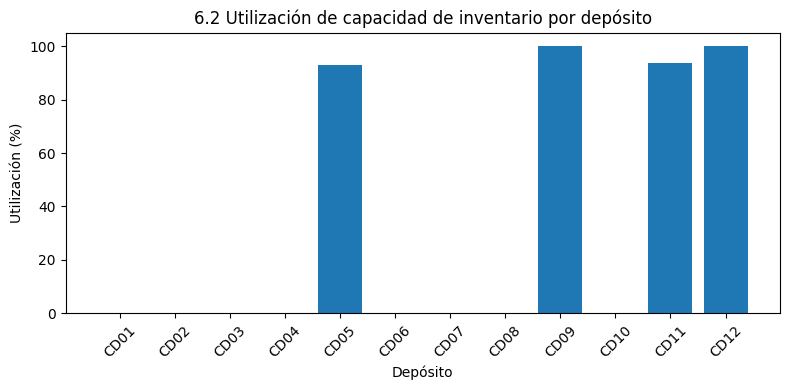

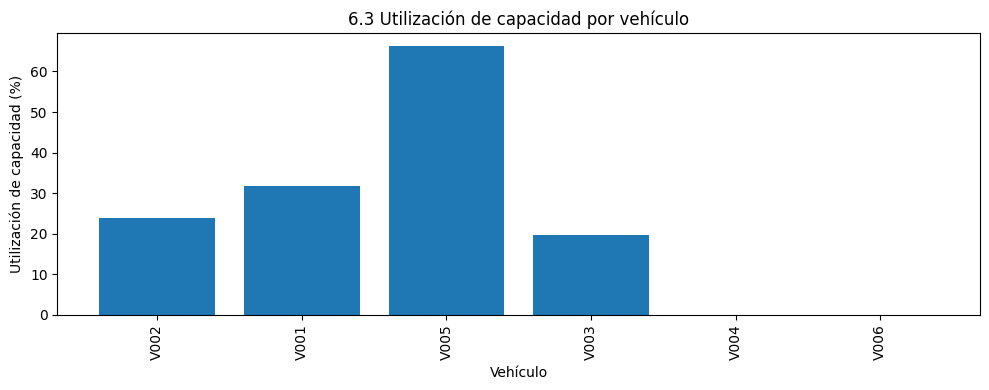

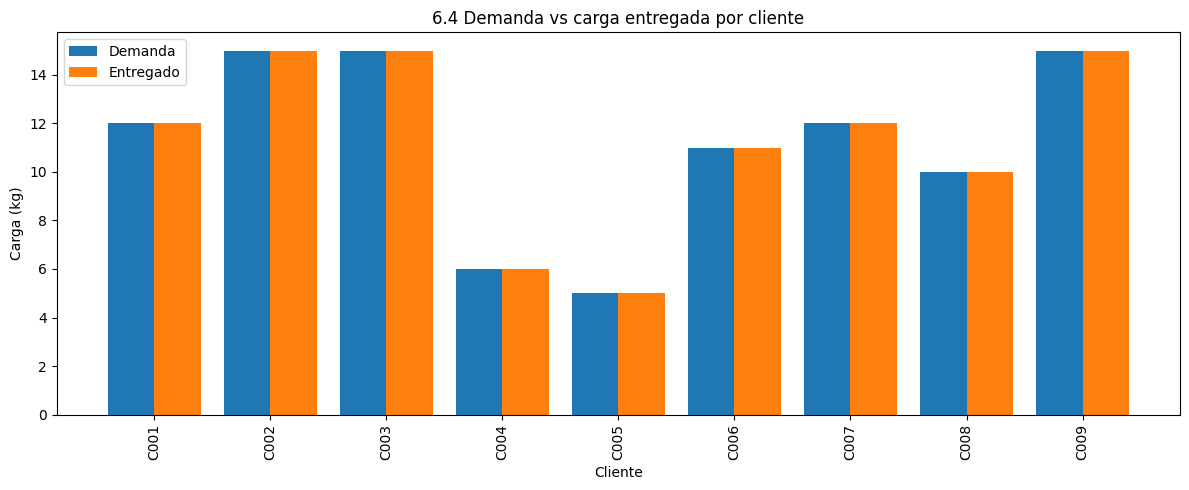

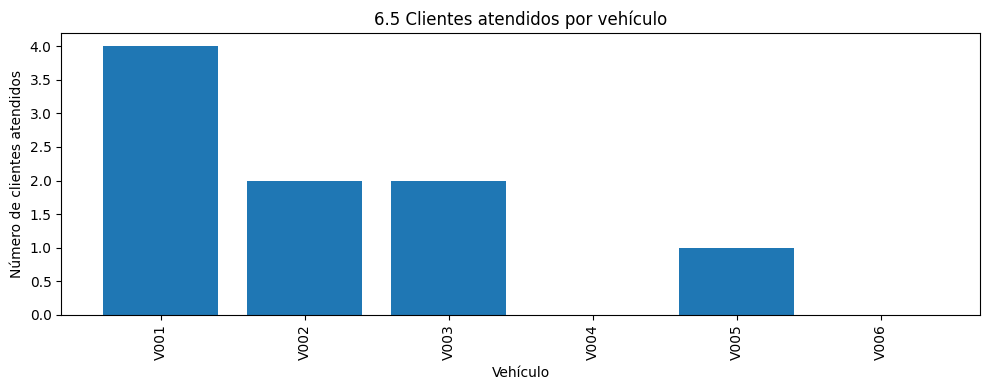

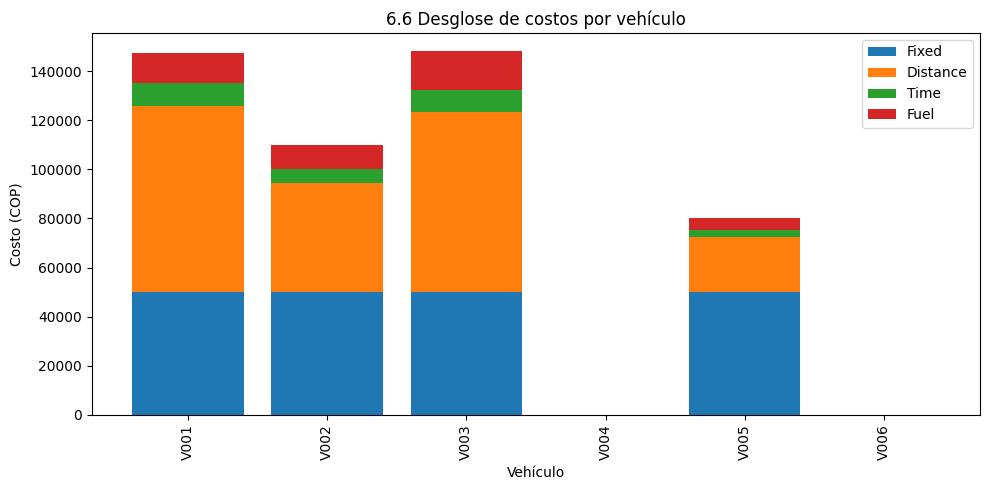

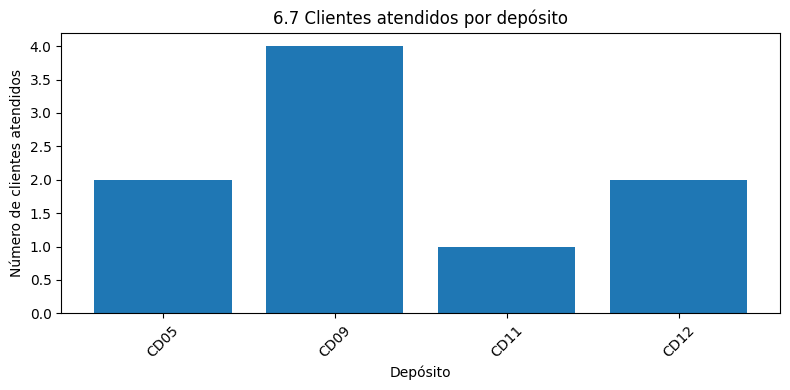

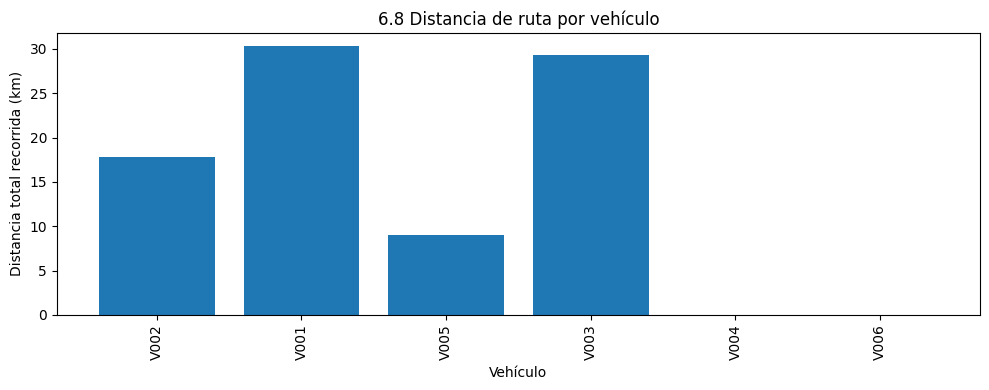

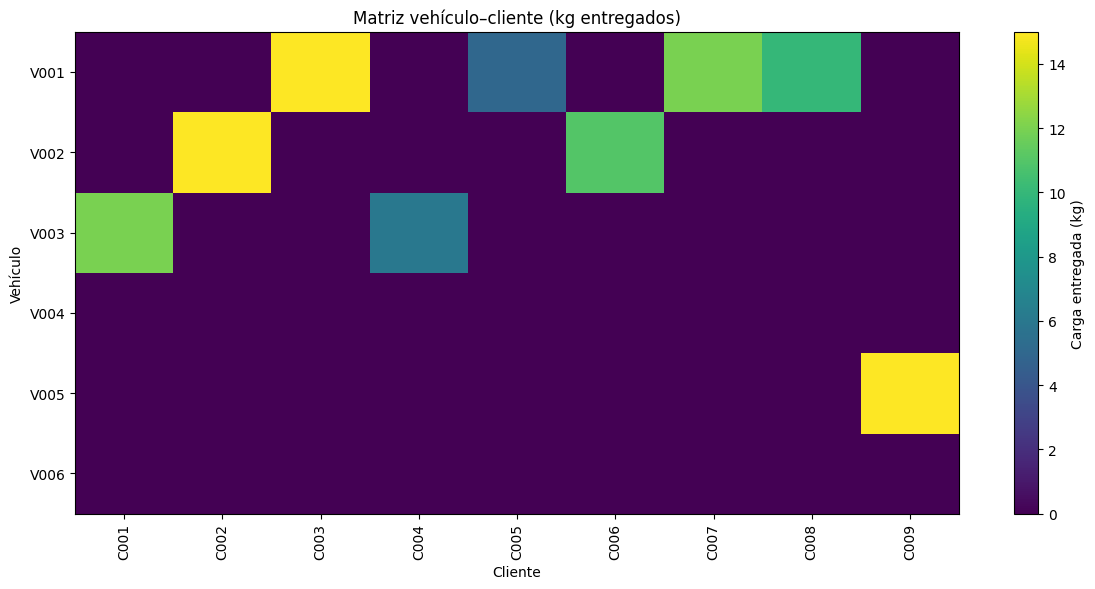

In [31]:
import matplotlib.pyplot as plt

# ------------- 6.2 Utilización de depósitos -------------
plt.figure(figsize=(8, 4))
x = depot_summary_df["DepotId"]
y = depot_summary_df["Utilization_%"]

plt.bar(x, y)
plt.xlabel("Depósito")
plt.ylabel("Utilización (%)")
plt.title("6.2 Utilización de capacidad de inventario por depósito")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------- 6.3 Utilización de vehículos -------------
plt.figure(figsize=(10, 4))
x = vehicle_summary_df["VehicleId"]
y = vehicle_summary_df["Utilization_%"]

plt.bar(x, y)
plt.xlabel("Vehículo")
plt.ylabel("Utilización de capacidad (%)")
plt.title("6.3 Utilización de capacidad por vehículo")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ------------- 6.4 Demanda vs entrega por cliente -------------
plt.figure(figsize=(12, 5))

idx = range(len(clients_demand_df))
width = 0.4

plt.bar(
    [i - width/2 for i in idx],
    clients_demand_df["Demand"],
    width=width,
    label="Demanda"
)
plt.bar(
    [i + width/2 for i in idx],
    clients_demand_df["Delivered"],
    width=width,
    label="Entregado"
)

plt.xticks(idx, clients_demand_df["ClientId"], rotation=90)
plt.xlabel("Cliente")
plt.ylabel("Carga (kg)")
plt.title("6.4 Demanda vs carga entregada por cliente")
plt.legend()
plt.tight_layout()
plt.show()

# ------------- 6.5 Clientes atendidos por vehículo -------------
vehicle_clients_count = []

for v in model.V:
    veh_std = vehicle_id_to_std[v]
    num_clients = sum(1 for c in model.C if value(model.q[c, v]) > 1e-6)
    vehicle_clients_count.append({"VehicleId": veh_std, "ClientsServed": num_clients})

vehicle_clients_count_df = pd.DataFrame(vehicle_clients_count)

plt.figure(figsize=(10, 4))
plt.bar(
    vehicle_clients_count_df["VehicleId"],
    vehicle_clients_count_df["ClientsServed"]
)
plt.xlabel("Vehículo")
plt.ylabel("Número de clientes atendidos")
plt.title("6.5 Clientes atendidos por vehículo")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ------------- 6.6 Gastos por vehículo (desglose FO) -------------
cost_rows = []

for v in model.V:
    veh_std = vehicle_id_to_std[v]
    y_use_v = float(value(model.y_use[v]))
    dist_v  = float(value(model.dist_v[v]))
    time_v  = float(value(model.time_v[v]))
    eff_v   = float(value(model.eff_v[v]))

    fixed_cost = float(value(model.C_fixed)) * y_use_v
    dist_cost  = float(value(model.C_dist))  * dist_v
    time_cost  = float(value(model.C_time))  * time_v
    fuel_cost  = (dist_v / eff_v) * float(value(model.fuel_price))

    total = fixed_cost + dist_cost + time_cost + fuel_cost

    cost_rows.append({
        "VehicleId": veh_std,
        "Fixed": fixed_cost,
        "Distance": dist_cost,
        "Time": time_cost,
        "Fuel": fuel_cost,
        "Total": total
    })

costs_df = pd.DataFrame(cost_rows)

plt.figure(figsize=(10, 5))
x = range(len(costs_df))
labels = costs_df["VehicleId"]

bottom = [0.0] * len(costs_df)
for comp in ["Fixed", "Distance", "Time", "Fuel"]:
    values = costs_df[comp].values
    plt.bar(x, values, bottom=bottom, label=comp)
    bottom = [b + v for b, v in zip(bottom, values)]

plt.xticks(x, labels, rotation=90)
plt.xlabel("Vehículo")
plt.ylabel("Costo (COP)")
plt.title("6.6 Desglose de costos por vehículo")
plt.legend()
plt.tight_layout()
plt.show()

# ------------- 6.7 Clientes atendidos por depósito -------------
clients_per_depot = (
    depot_clients_df.groupby("DepotId")["ClientId"]
    .nunique()
    .reset_index()
    .rename(columns={"ClientId": "ClientsServed"})
)

plt.figure(figsize=(8, 4))
plt.bar(
    clients_per_depot["DepotId"],
    clients_per_depot["ClientsServed"]
)
plt.xlabel("Depósito")
plt.ylabel("Número de clientes atendidos")
plt.title("6.7 Clientes atendidos por depósito")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------- 6.8 Rutas por vehículo (distancia) -------------
plt.figure(figsize=(10, 4))

x = vehicle_summary_df["VehicleId"]
y = vehicle_summary_df["Distance_km"]

plt.bar(x, y)
plt.xlabel("Vehículo")
plt.ylabel("Distancia total recorrida (km)")
plt.title("6.8 Distancia de ruta por vehículo")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ------------- Extra: heatmap vehículo–cliente (opcional, muy útil) -------------
plt.figure(figsize=(12, 6))
plt.imshow(vehicle_client_matrix_df.values, aspect="auto")
plt.colorbar(label="Carga entregada (kg)")
plt.xticks(range(len(vehicle_client_matrix_df.columns)), vehicle_client_matrix_df.columns, rotation=90)
plt.yticks(range(len(vehicle_client_matrix_df.index)), vehicle_client_matrix_df.index)
plt.xlabel("Cliente")
plt.ylabel("Vehículo")
plt.title("Matriz vehículo–cliente (kg entregados)")
plt.tight_layout()
plt.show()
